<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dataset-handling" data-toc-modified-id="Dataset-handling-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dataset handling</a></span></li><li><span><a href="#Simplest-effects-of-CP-on-percent-correct" data-toc-modified-id="Simplest-effects-of-CP-on-percent-correct-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Simplest effects of CP on percent correct</a></span></li><li><span><a href="#Logistic-regression" data-toc-modified-id="Logistic-regression-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Logistic regression</a></span><ul class="toc-item"><li><span><a href="#Single-predictor" data-toc-modified-id="Single-predictor-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Single predictor</a></span><ul class="toc-item"><li><span><a href="#Signed-coherence" data-toc-modified-id="Signed-coherence-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Signed coherence</a></span></li><li><span><a href="#Viewing-duration" data-toc-modified-id="Viewing-duration-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Viewing duration</a></span></li><li><span><a href="#VD-x-signedCoh" data-toc-modified-id="VD-x-signedCoh-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>VD x signedCoh</a></span></li></ul></li><li><span><a href="#Two-predictors" data-toc-modified-id="Two-predictors-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Two predictors</a></span></li></ul></li><li><span><a href="#With-quickpsy-package" data-toc-modified-id="With-quickpsy-package-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>With <code>quickpsy</code> package</a></span></li><li><span><a href="#With-glm-function" data-toc-modified-id="With-glm-function-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>With <code>glm</code> function</a></span></li></ul></div>

<!--
IRdisplay::display_html(file='../code_hiding.html')
if the line above generates an error, it could be due to this:
https://github.com/IRkernel/IRdisplay/issues/41
In the meantime, the code below is enough; it works on nbviewer but not on the notebook directly
-->

<script>
  code_show=true;
  function code_toggle() {
    if (code_show){
      $('div.input').hide();
    } else {
      $('div.input').show();
    }
    code_show = !code_show
  } 
  $( document ).ready(code_toggle);
</script>
<font size=4>
<a href="javascript:code_toggle()">Toggle ON/OFF</a>
code cells.
</font>

# Fitting psychometric functions

This notebook analyzes data from `Pilot 11` dataset.

In [1]:
library(data.table)
library(ggplot2)        

In [2]:
# library(tidyverse) # masks data.table, so not good for now

In [3]:
# library(psych)
my_logistic <- function(x_vals, linear_func) {
    return(exp(linear_func(x_vals))/(1+exp(linear_func(x_vals))))
}

In [4]:
linear_func <- function(coefs) {
    f <- function(x) {
        return(coefs[1]+coefs[2]*x)
    }
    return(f)
}

In [5]:
fit_logistic_single_pred <- function(datatable, response, response_value, predictor) {
    logistic_fit <- substitute(glm(response ~ predictor, family=binomial(), data=datatable))
    print(summary(eval(logistic_fit)))
    betas <- coef(eval(logistic_fit))
#     print(betas)
    x <- substitute(
        unique(datatable[order(predictor),.(predictor),by=.(predictor)][,predictor])
        )
    fit_prop <- my_logistic(eval(x), linear_func(betas))
    fitted_curve <- data.table(x=eval(x), y=fit_prop)
    
    # control output figure size
    options(repr.plot.width=8, repr.plot.height=4)
    g <- substitute(
        ggplot(datatable[,.(prop=sum(response==response_value)/.N),by=predictor], aes(x=predictor, y=prop)) + 
        geom_point() +
        geom_line(aes(x=x, y=y),data=fitted_curve,inherit.aes=FALSE) +
        ylim(0,1)
        )
    return(eval(g))
}

## Dataset handling

Let's load and inspect the dataset.

In [6]:
# load dataset
data <- fread('../../data/Pilot13-14/psychophysical_data.csv')
data[,presenceCP:=as.factor(presenceCP)]
data[,choice:=as.factor(choice)]

In [7]:
data[,signedCohLast := coherence]
data[signedCoherence < 0, signedCohLast := signedCoherence]
data[choice=="left" & presenceCP=="yes" & correct, signedCohLast:= - coherence]
data[choice=="right" & presenceCP=="yes" & !correct, signedCohLast:= - coherence]

In [8]:
str(data)

Classes ‘data.table’ and 'data.frame':	977 obs. of  12 variables:
 $ pilotID        : int  13 13 13 13 13 13 13 13 13 13 ...
 $ taskID         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ validTrialCount: int  1 2 3 4 5 6 7 8 9 10 ...
 $ choice         : Factor w/ 2 levels "left","right": 2 1 1 2 2 1 2 1 2 2 ...
 $ correct        : logi  TRUE FALSE TRUE TRUE TRUE TRUE ...
 $ presenceCP     : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ viewingDuration: num  0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 0.2 ...
 $ signedCoherence: num  50 50 -57 57 56 -56 56 -55 55 55 ...
 $ coherence      : num  50 50 57 57 56 56 56 55 55 55 ...
 $ choice_time    : num  0.363 0.833 0.578 0.572 0.633 ...
 $ exactVD        : num  0.22 0.203 0.203 0.219 0.219 ...
 $ signedCohLast  : num  50 50 -57 57 56 -56 56 -55 55 55 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [9]:
print('first 6 rows of data.table')
head(data)

[1] "first 6 rows of data.table"


pilotID,taskID,validTrialCount,choice,correct,presenceCP,viewingDuration,signedCoherence,coherence,choice_time,exactVD,signedCohLast
13,1,1,right,TRUE,no,0.2,50,50,0.3633654,0.2203390,50
13,1,2,left,FALSE,no,0.2,50,50,0.8330632,0.2033898,50
13,1,3,left,TRUE,no,0.2,-57,57,0.5782815,0.2033898,-57
13,1,4,right,TRUE,no,0.2,57,57,0.5724611,0.2193786,57
13,1,5,right,TRUE,no,0.2,56,56,0.6325272,0.2188400,56
13,1,6,left,TRUE,no,0.2,-56,56,0.6130831,0.2033898,-56


## Simplest effects of CP on percent correct

**Question:** Does the physical presence of a CP affect state inference?  
**Hypotheses:** At fixed viewing duration the (physical) presence of a CP will decrease accuracy.  
**Method:** Hypothesis testing, i.e. is the difference in percent correct between the `CP` and `nonCP` conditions significantly different from 0?

Let's build a contingency table and perform [Fisher's exact test](https://en.wikipedia.org/wiki/Fisher%27s_exact_test#Example).

In [12]:
subj <- '13'
task <- '2'
maxCoh <- as.numeric(data[pilotID==subj & taskID==task, max(coherence)])
cat('max coh for subject', subj, 'on task', task, 'is', maxCoh, '\n')
contingency <- as.matrix(data[pilotID==subj & taskID==task & coherence>0 & coherence < maxCoh, 
                              .(Corrrect=sum(correct),Incorrect=sum(!correct)), by=presenceCP], rownames=TRUE)
t(contingency)
fisher.test(t(contingency)) # two-sided test; see ?fisher.test for help

max coh for subject 13 on task 2 is 51.81503 


,yes,no
Corrrect,37,68
Incorrect,8,18



	Fisher's Exact Test for Count Data

data:  t(contingency)
p-value = 0.8184
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.4519949 3.5749370
sample estimates:
odds ratio 
  1.222411 


In [13]:
subj <- '14'
task <- '2'
maxCoh <- as.numeric(data[pilotID==subj & taskID==task, max(coherence)])
cat('max coh for subject', subj, 'on task', task, 'is', maxCoh, '\n')
contingency <- as.matrix(data[pilotID==subj & taskID==task & coherence>0 & coherence < maxCoh, 
                              .(Corrrect=sum(correct),Incorrect=sum(!correct)), by=presenceCP], rownames=TRUE)
t(contingency)
fisher.test(t(contingency)) # two-sided test; see ?fisher.test for help

max coh for subject 14 on task 2 is 32.20934 


,yes,no
Corrrect,26,72
Incorrect,17,17



	Fisher's Exact Test for Count Data

data:  t(contingency)
p-value = 0.01866
alternative hypothesis: true odds ratio is not equal to 1
95 percent confidence interval:
 0.1492558 0.8804068
sample estimates:
odds ratio 
  0.364209 


We conclude that the test is not significant, i.e., we do **not** reject the null hypothesis that percent correct is the same with and without change points.

In [ ]:
# we could run the same test for a higher coherence value (uncomment the following)
# contingency2 <- as.matrix(data[coherence==48, .(Corrrect=sum(correct),Incorrect=sum(!correct)), by=presenceCP], rownames=TRUE)
# fisher.test(t(contingency2)) 

In [ ]:
# fisher.test(t(contingency), alternative="less")

In [ ]:
# fisher.test(t(contingency), alternative="greater")

## Logistic regression

### Single predictor

#### Signed coherence
<a id="cohpred"></a>

We start super simple with the equation:
$$\log\frac{p_i}{1-p_i}=\beta_0+\beta_1x^\text{sc}_i$$
where $p_i$ is the proportion of right choices at stimulus level $i$ and $x^\text{sc}$ is the signed coherence value.
The current data (Pilot 11) has 11 stimulus levels, which correspond to the 11 signed coherence values: 

In [14]:
subj <- '13'
task <- '2'

In [15]:
unique(data[pilotID==subj & taskID==task & order(signedCohLast),.(signedCohLast)][,signedCohLast])

[1]  37.00000  51.81503   0.00000 -51.81503 -37.00000


Call:
glm(formula = choice ~ signedCohLast, family = binomial(), data = data[pilotID == 
    subj & taskID == task])

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8266  -1.0684  -0.5078   0.8028   2.0553  

Coefficients:
               Estimate Std. Error z value Pr(>|z|)    
(Intercept)   -0.261997   0.118744  -2.206   0.0274 *  
signedCohLast  0.033219   0.003624   9.167   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 539.34  on 391  degrees of freedom
Residual deviance: 428.71  on 390  degrees of freedom
AIC: 432.71

Number of Fisher Scoring iterations: 3



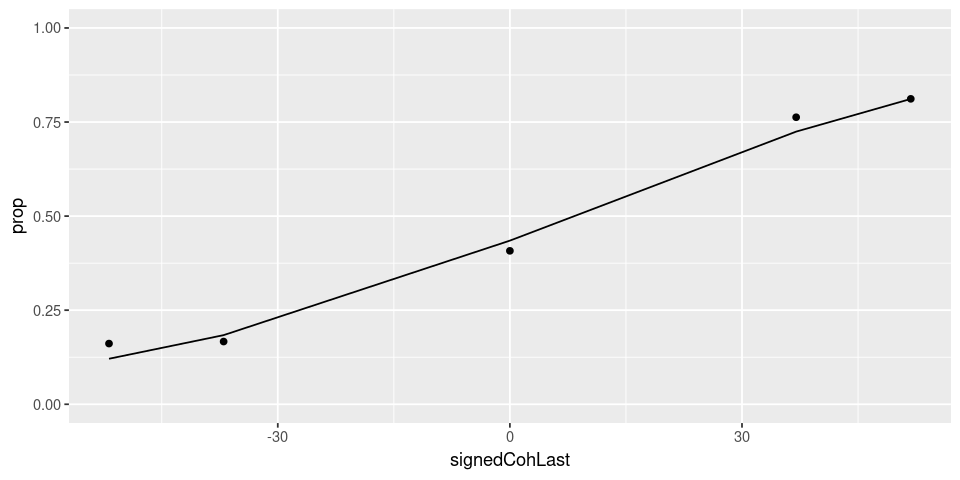

In [16]:
fit_logistic_single_pred(data[pilotID==subj & taskID==task], choice, "right", signedCohLast)

In [17]:
subj <- '14'
unique(data[pilotID==subj & taskID==task & order(signedCohLast),.(signedCohLast)][,signedCohLast])

[1]   0.00000 -32.20934  32.20934  23.00000 -23.00000


Call:
glm(formula = choice ~ signedCohLast, family = binomial(), data = data[pilotID == 
    subj & taskID == task])

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.85048  -0.79604  -0.01596   1.15428   1.80190  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)   0.054682   0.113557   0.482     0.63    
signedCohLast 0.045280   0.005422   8.351   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 543.43  on 391  degrees of freedom
Residual deviance: 457.90  on 390  degrees of freedom
AIC: 461.9

Number of Fisher Scoring iterations: 4



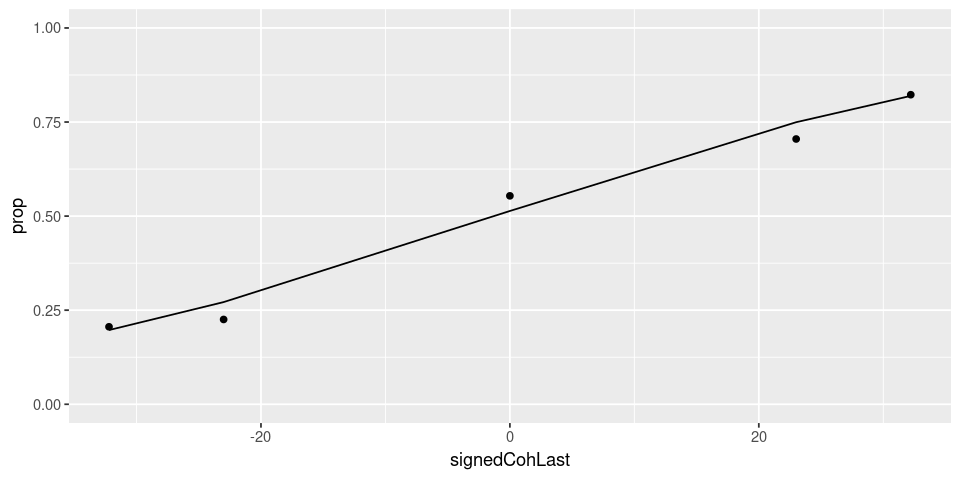

In [18]:
fit_logistic_single_pred(data[pilotID==subj & taskID==task], choice, "right", signedCohLast)

The z-value for the intercept term $\beta_0$ is usually not useful. However, for the $\beta_1$ term, it allows us to test the null hypothesis that $\beta_1=0$. Since the p-value is extremely small ($<10^{-16}$), the test is significant and we reject the null hypothesis. In other words, **there is an effect of signed coherence on the likelihood for the subject to choose "right".**

Plotting the fitted curve together with the raw data yields:

#### Viewing duration

**With prob(choose right)**

Now, what does the same fitting procedure look like if we change the predictor to be viewing duration (note that now, $i$ denotes the various exact viewing durations)?
$$\log\frac{p_i}{1-p_i}=\beta_0+\beta_1x^\text{vd}_i$$


In [ ]:
fit_logistic_single_pred(data, choice, "right", viewingDuration)

**With percent correct**

It could make more sense to look at percentage correct. Note how, now, the intercept coefficient will be interpretable:

In [ ]:
fit_logistic_single_pred(data, correct, TRUE, viewingDuration)

Fitting a line to the plot above looks quite indistinguishable.

In [ ]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=4)
ggplot(data[, .(pCorrect=sum(correct)/.N), by=viewingDuration], aes(x=viewingDuration, y=pCorrect)) +
    geom_point() +
    geom_smooth(se = FALSE, method = lm, show.legend=TRUE) +
    ylim(0,1)

**percent correct with log(VD)**

Let's first redo the last fit with the log of the viewing duration.

In [ ]:
# logistic_fit_3_log <- glm(correct ~ log(viewingDuration), family=binomial(), data=data)
# summary(logistic_fit_3_log)
# betas_3_log <- coef(logistic_fit_3_log)
# print(betas_3_log)
# x_3_log <- log(x_3)
# fit_3_prop_log <- my_logistic(x_3_log, linear_func(betas_3_log))
# fitted_curve_3_log <- data.table(x=x_3_log, y=fit_3_prop_log)

In [ ]:
# # control output figure size
# options(repr.plot.width=8, repr.plot.height=5)
# ggplot(data[,.(pCorrect=sum(correct)/.N),by=viewingDuration], aes(x=log(viewingDuration), y=pCorrect)) + 
#     geom_point() +
#     geom_line(aes(x=x, y=y),data=fitted_curve_3_log,inherit.aes=FALSE) +
#     ylim(0,1)

This looks the same. Not sure how to interpret the intercept.

#### VD x signedCoh 

Here, $i$ is the level of signed coherence, and $x^\text{prod}$ is the product of VD and signed coherence.
$$\log\frac{p_i}{1-p_i}=\beta_0+\beta_1x^\text{prod}_i$$ 

In [ ]:
data[,prod:=signedCohLast * viewingDuration]
str(data)

In [ ]:
fit_logistic_single_pred(data, choice, "right", prod)

Fit definitely seems poorer than [here](#cohpred).

### Two predictors

## With `quickpsy` package

In [ ]:
# for an explanation of masked objects, see here:
# https://stackoverflow.com/a/39137111
library(quickpsy)

In [ ]:
# let's set presenceCP as factor variable in a temporary data.table before upcoming grouping
tmp <- data[,`:=`(presenceCP=as.factor(presenceCP))]

# build data.table used by the quickpsy package
psychometric <- tmp[, 
                    .(numCorrect=sum(correct), N=.N), 
                    by=.(coherence, viewingDuration, presenceCP)]
psychometric[coherence==0, numCorrect:=as.integer(N/2)]
str(psychometric)

$$\psi(x)=\gamma + (1-\gamma-\lambda) * F(x)$$
where $\gamma$ is the guess rate, $\lambda$ is the lapse rate and $F$ is a sigmoidal-shape function with asymptotes at 0 and 1.

In [ ]:
fitWithLapses <- quickpsy(psychometric, 
                          coherence, 
                          numCorrect, N,
                          grouping = c(viewingDuration, presenceCP), lapses  = T, bootstrap = 'none') 

ggplot() +
  facet_grid(viewingDuration~presenceCP) +
  geom_point(data = fitWithLapses$averages, 
             aes(x = coherence, y = prob)) +
  geom_line(data = fitWithLapses$curves, 
            aes(x = x, y = y)) +
  ylim(0, 1.25) # we include ggplot ylim to be able to visualize what is going on

In [ ]:
# perform the fits
# ref here:
# http://dlinares.org/lapsesquickpsy.html
fit <- quickpsy(psychometric, coherence, numCorrect, N, grouping = .(viewingDuration, presenceCP),
               log=FALSE, fun=logistic_fun, lapses=TRUE, bootstrap="nonparametric")

In [ ]:
str(fit)

In [ ]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=5)
plot(fit) + xlim(c(0,60))

In [ ]:
# control output figure size
options(repr.plot.width=8, repr.plot.height=3)
plotpar(fit) #+ ylim(c(0,.25))

In [ ]:
plotthresholds(fit) + ylim(c(-60,60))


## With `glm` function

In [ ]:
# psychometric[,numChooseLeft := N - numChooseRight]
# str(psychometric)

In [ ]:
# # let's first follow this example:
# # http://www.dlinares.org/psychopract.html#fitting-using-generalized-linear-models
# model <- glm( cbind(numChooseRight, numChooseLeft) ~ signedCoherence, 
#              data= psychometric, 
#              family = binomial(probit))

# xseq <- seq(-60, 60, 1)
# yseq <- predict(model, data.frame(signedCoherence = xseq), type = 'response')
# curve <- data.frame(xseq, yseq)

# p <- ggplot() +
#   geom_point(data = psychometric[,.(signedCoherence, chooseRight=numChooseRight / N)], 
#              aes(x = signedCoherence, y = chooseRight)) +
#   geom_line(data = curve,aes(x = xseq, y = yseq))
# p

The problem here is that I have a single regressor, namely, `signedCoherence`. This is not what I want.

In [ ]:
# Try instead this example
#https://www.statmethods.net/advstats/glm.html
# with good interpretation here:
# https://stats.idre.ucla.edu/r/dae/logit-regression/

In [ ]:
fit2 <- glm(choice ~ signedCohLast * exactVD + presenceCP, data = data, family=binomial())

In [ ]:
summary(fit2)

In [ ]:
anova(fit2)

In [ ]:
confint(fit2) # 95% CI for the coefficients, using profiled log-likelihood
confint.default(fit2)  # CIs using standard errors

In [ ]:
# odds ratios and 95% CI
exp(cbind(OddsRatio = coef(fit2), confint(fit2)))

In [ ]:
library("aod")
wald.test(b = coef(fit2), Sigma = vcov(fit2), Terms = 4)

In [ ]:
# better to use this
# https://stats.idre.ucla.edu/r/dae/logit-regression/
predict(fit2, type="response") # predicted values
residuals(fit2, type="deviance") # residuals

In [ ]:
cdplot(choice~signedCoherence, data=tmp_glm) 

In [ ]:
cdplot(choice~viewingDuration, data=tmp_glm) 

In [ ]:
# now try this
#https://datascienceplus.com/perform-logistic-regression-in-r/

# Psychophysics tutorial